Using the BRDF module
====================

In this notebook, we demonstrate how to use the pySCATMECH BRDF module. This module defines the class `BRDF_Model`, which provides an interface to SCATMECH's `BRDF_Model`, which in turn, is a base class for representing all models that predict the bidirectional reflectance distribution function (BRDF). 

First, we import the necessary libraries. We will be using `matplotlib.pyplot` for graphing.

In [1]:
from pySCATMECH.brdf import *
import matplotlib.pyplot as plt

Let's create a `Correlated_Roughness_Stack_BRDF_Model` and print its default parameters.

In [2]:
model = BRDF_Model('Correlated_Roughness_Stack_BRDF_Model')
print(model)

{None : 'Correlated_Roughness_Stack_BRDF_Model',
'lambda' : '0.532',
'substrate' : '(4.05,0.05)',
'type' : '0',
'psd' : {None : 'ABC_PSD_Function',
          'A' : '0.01',
          'B' : '362',
          'C' : '2.5'},
'stack' : 'No_StackModel'}


We can create the model with parameters. Notice in the following how we can set parameters that are themselves models.

In [3]:
psd = {None : "ABC_PSD_Function",
       "A" : 0.01,
       "B" : 360,
       "C" : 2.4}

stack = {None : 'SingleFilm_StackModel',
         'material' : 1.59,
         'thickness': 0.05
        }

parameters = {'lambda' : 0.532,
              'substrate' : 4.05+0.05j,
              'type' : 0,
              'stack' : stack,
              'psd' : psd}

model = BRDF_Model('Correlated_Roughness_Stack_BRDF_Model',parameters)
print(model)

{None : 'Correlated_Roughness_Stack_BRDF_Model',
'lambda' : '0.532',
'substrate' : '(4.05,0.05)',
'type' : '0',
'psd' : {None : 'ABC_PSD_Function',
          'A' : '0.01',
          'B' : '360',
          'C' : '2.4'},
'stack' : {None : 'SingleFilm_StackModel',
            'material' : '(1.59,0)',
            'thickness' : '0.05'}}


We can set parameters later using the `setParameters` function.

In [4]:
parameters['lambda'] = 0.600
psd['C'] = 2.3
stack['thickness'] = 0.1
model.setParameters(parameters)
print(model)

{None : 'Correlated_Roughness_Stack_BRDF_Model',
'lambda' : '0.6',
'substrate' : '(4.05,0.05)',
'type' : '0',
'psd' : {None : 'ABC_PSD_Function',
          'A' : '0.01',
          'B' : '360',
          'C' : '2.3'},
'stack' : {None : 'SingleFilm_StackModel',
            'material' : '(1.59,0)',
            'thickness' : '0.1'}}


One can use keyword arguments to set parameters, and if the parameters are models, one can set them to models. Note that because `lambda` is a Python keyword, we use `wavelength` in place of the parameter `lambda`.

In [5]:
# Needed to use OpticalFunction, Film, and FilmStack...
from pySCATMECH.fresnel import *

# Define two materials...
SiO2 = OpticalFunction(lambda L: 1.4580 + 0.00354/L**2,np.arange(0.2,1.5,0.1))
Si = OpticalFunction('silicon')

# Define the power spectral density function...
psd = Model("ABC_PSD_Function", A=0.01, B=360, C=2.4)

# Define the stack...
stack =  FilmStack([Film(SiO2,thickness =0.05)])

model.setParameters(wavelength = 0.600, substrate=Si, stack = stack, psd = psd)
print(model)

{None : 'Correlated_Roughness_Stack_BRDF_Model',
'lambda' : '0.6',
'substrate' : 'silicon',
'type' : '0',
'psd' : {None : 'ABC_PSD_Function',
          'A' : '0.01',
          'B' : '360',
          'C' : '2.4'},
'stack' : {None : 'Stack_StackModel',
            'stack' : 'zm95qrx7RMFx.tmp 0.05'}}


In [6]:
model.getParameters()

{None: 'Correlated_Roughness_Stack_BRDF_Model',
 'lambda': '0.6',
 'substrate': 'silicon',
 'type': '0',
 'psd': 'ABC_PSD_Function',
 'psd.A': '0.01',
 'psd.B': '360',
 'psd.C': '2.4',
 'stack': 'Stack_StackModel',
 'stack.stack': 'zm95qrx7RMFx.tmp 0.05'}

Let's evaluate the BRDF! The BRDF, in general, is a Mueller matrix. (Note here that `deg` is defined in pySCATMECH to be $\pi/180$.) Let's evaluate it for incident and scattering angles, $\theta_i=60^\circ$ and $\theta_s=30^\circ$, respectively: 

In [7]:
print(model.MuellerBRDF(60*deg, 30*deg))

[[ 4.21363211e-06  6.14518402e-07  0.00000000e+00  0.00000000e+00]
 [ 6.14518402e-07  4.21363211e-06 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00 -3.83310078e-06  1.63841420e-06]
 [ 0.00000000e+00  0.00000000e+00 -1.63841420e-06 -3.83310078e-06]]


We can determine it for an input Stokes vector of p-polarization and with polarization insensitivity:

In [8]:
mBRDF = model.MuellerBRDF(60*deg, 30*deg)
inc = Polarization('p')
sens = Sensitivity('u')
sens @ mBRDF @ inc

3.599113704481351e-06

Another way of doing this is:

In [9]:
model.BRDF(60*deg, 30*deg, inc=Polarization('p'), sens=Sensitivity('u'))

3.599113704481351e-06

The unpolarized BRDF is:

In [10]:
model.BRDF(60*deg, 30*deg)

4.2136321066656146e-06

Let's plot the BRDF:

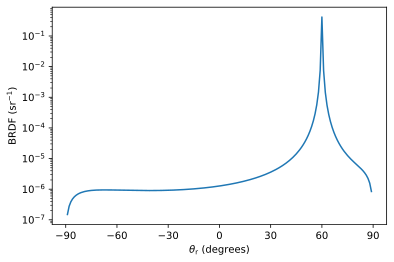

In [11]:
thetaslist = np.arange(-89, 90, 1)
BRDFlist = [model.BRDF(60*deg, thetas*deg, inc=[1,-1,0,0], sens=[1,0,0,0]) for thetas in thetaslist]

plt.figure()
plt.yscale('log')
plt.plot(thetaslist,BRDFlist)
plt.ylabel('BRDF (sr$^{-1}$)')
plt.xlabel(r'$\theta_\mathrm{r}$ (degrees)')
plt.xticks(np.linspace(-90,90,7))
plt.show()

We can vary two angles:

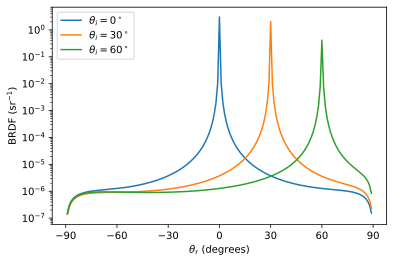

In [12]:
thetaslist = np.arange(-89,90,1) 
plt.figure()
plt.yscale('log')
for thetai in [0,30,60]:
    BRDFlist = [model.BRDF(thetai*deg,thetas*deg,inc=[1,-1,0,0],sens=[1,0,0,0]) for thetas in thetaslist]
    plt.plot(thetaslist,BRDFlist,label = r"$\theta_i=%d^\circ$" % thetai)

plt.xticks(np.linspace(-90,90,7))
plt.ylabel('BRDF (sr$^{-1}$)')
plt.xlabel(r'$\theta_\mathrm{r}$ (degrees)')
plt.legend()
plt.show()

We can even vary parameters. Also, note that sometimes it is useful to plot BRDF on a logarithmic scale.

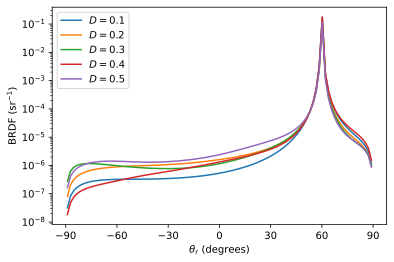

In [13]:
thetaslist = np.linspace(-89,89,100) 

plt.figure()
for t in [0.1,0.2,0.3,0.4,0.5]:
    stack = FilmStack([Film(SiO2,thickness = t)])
    model.setParameters(stack=stack)
    BRDFlist = [model.BRDF(60*deg,thetas*deg,inc=[1,-1,0,0],sens=[1,0,0,0]) for thetas in thetaslist]
    plt.plot(thetaslist,BRDFlist,label = r"$D = %g$" % t)
    
plt.yscale('log')
plt.xticks(np.linspace(-90,90,7))
plt.xlabel(r'$\theta_\mathrm{r}$ (degrees)')
plt.ylabel('BRDF (sr$^{-1}$)')
plt.legend()
plt.show()